In [4]:
import os
import sys
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use('ggplot')


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


In [6]:
def fetch_data(ticker, start, end):
    import yfinance as yf
    df = yf.download(ticker, start=start, end=end)
    df.dropna(inplace=True)
    return df


In [15]:
from data_loader import fetch_data

start_date = "2020-01-01"
end_date = "2024-01-01"

df = fetch_data('AAPL', start_date, end_date)
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.7161,72.7766,71.4668,71.7210,135480400
2020-01-03,72.0091,72.7717,71.7840,71.9413,146322800
2020-01-06,72.5829,72.6217,70.8761,71.1279,118387200
2020-01-07,72.2415,72.8492,72.0212,72.5926,108872000
2020-01-08,73.4036,73.7063,71.9438,71.9438,132079200


In [16]:
def check_missing(df):
    """
    Prints the number of missing values per column.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    pd.Series: A series containing the count of missing values per column.
    """
    return df.isnull().sum()

check_missing(df)


Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

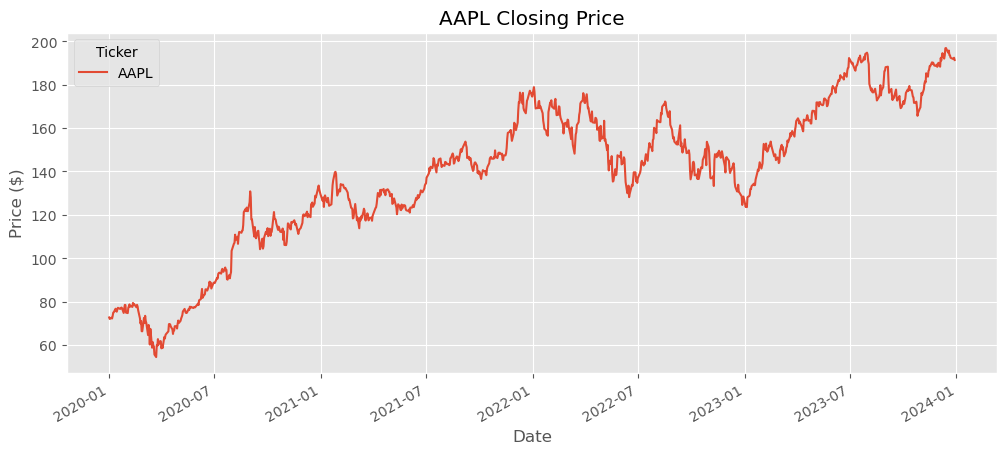

In [17]:
def plot_close(df, title='Closing Price Over Time'):
    """
    Plots the closing price of a stock over time.

    Parameters:
    df (pd.DataFrame): The DataFrame containing stock data with a 'Close' column.
    title (str): The title for the plot.
    """
    df['Close'].plot(figsize=(12, 5), title=title)
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.show()

plot_close(df, title='AAPL Closing Price')


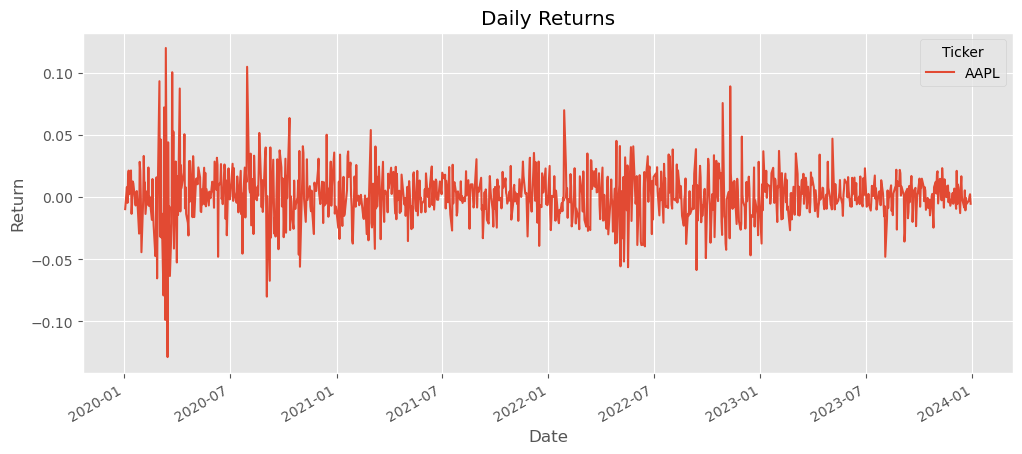

In [18]:
def plot_daily_returns(df):
    """
    Calculates and plots daily percentage returns of the stock.

    Parameters:
    df (pd.DataFrame): The DataFrame with a 'Close' column.
    """
    daily_returns = df['Close'].pct_change()
    daily_returns.plot(figsize=(12, 5), title='Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.show()

plot_daily_returns(df)


In [22]:
def build_combined_close_df(*dfs, tickers):
    """
    Combines 'Close' prices from multiple stock DataFrames into a single DataFrame.

    Parameters:
    *dfs: Variable number of DataFrames, each containing a 'Close' column.
    tickers (list of str): Corresponding stock ticker names for column naming.

    Returns:
    pd.DataFrame: Combined DataFrame with 'Close' prices for each ticker.
    """
    close_prices = [df['Close'] for df in dfs]
    combined = pd.concat(close_prices, axis=1)
    combined.columns = tickers
    return combined

combined_df = build_combined_close_df(aapl_df, msft_df, tickers=['AAPL', 'MSFT'])
combined_df.head()


,AAPL,MSFT
Date,,
2020-01-02,72.7161,153.3233
2020-01-03,72.0091,151.4141
2020-01-06,72.5829,151.8055
2020-01-07,72.2415,150.4213
2020-01-08,73.4036,152.8173


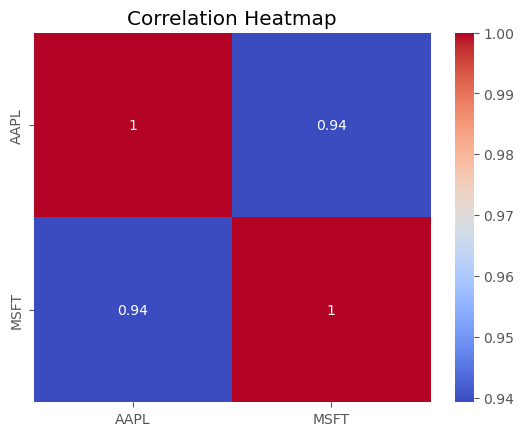

In [23]:
import seaborn as sns

def plot_correlation_heatmap(df):
    """
    Plots a correlation heatmap of the given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with numerical columns to correlate.
    """
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(combined_df)


In [24]:
from sklearn.linear_model import LinearRegression

def get_hedge_ratio(y, x):
    """
    Estimates the hedge ratio (beta) by regressing y ~ x.

    Parameters:
    y (pd.Series): Dependent variable (e.g., AAPL close prices)
    x (pd.Series): Independent variable (e.g., MSFT close prices)

    Returns:
    float: Hedge ratio (slope of the regression line)
    """
    model = LinearRegression().fit(x.values.reshape(-1, 1), y.values)
    return model.coef_[0]

hedge_ratio = get_hedge_ratio(combined_df['AAPL'], combined_df['MSFT'])
print(f"Hedge Ratio: {hedge_ratio:.4f}")


Hedge Ratio: 0.5697


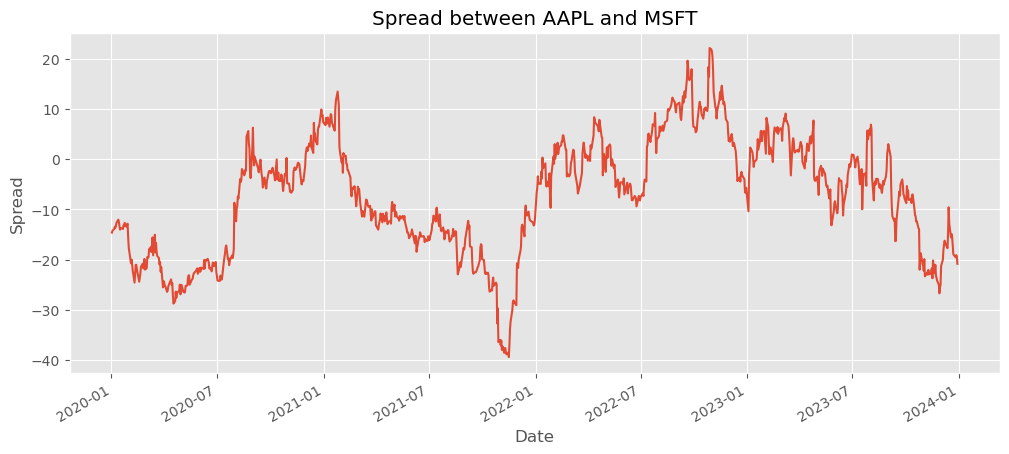

In [26]:
def compute_spread(y, x, hedge_ratio):
    """
    Computes the spread between two price series given a hedge ratio.

    Parameters:
    y (pd.Series): First stock price series (e.g., AAPL)
    x (pd.Series): Second stock price series (e.g., MSFT)
    hedge_ratio (float): Ratio to hedge x against y

    Returns:
    pd.Series: The calculated spread
    """
    return y - hedge_ratio * x

spread = compute_spread(combined_df['AAPL'], combined_df['MSFT'], hedge_ratio)
spread.plot(figsize=(12, 5), title='Spread between AAPL and MSFT')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()


In [27]:
def generate_zscore_signals(spread, entry_z=1.0, exit_z=0.0):
    """
    Generates long/short signals based on Z-score of spread.

    Parameters:
    spread (pd.Series): Spread time series.
    entry_z (float): Z-score threshold for entering trades.
    exit_z (float): Z-score threshold for exiting trades.

    Returns:
    pd.Series: Trading signals (+1 for long, -1 for short, 0 for neutral).
    """
    zscore = (spread - spread.mean()) / spread.std()
    
    signal = pd.Series(index=spread.index, data=0)
    signal[zscore > entry_z] = -1  # Short spread
    signal[zscore < -entry_z] = 1  # Long spread
    signal[abs(zscore) < exit_z] = 0  # Exit signal
    
    return signal, zscore

signals, zscore = generate_zscore_signals(spread)


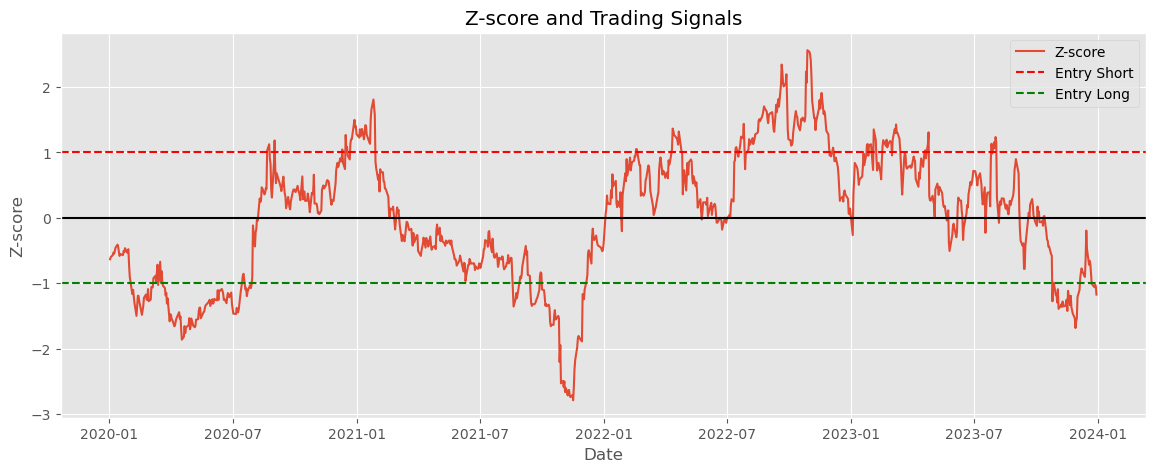

In [28]:
def plot_zscore_with_signals(zscore, signals):
    """
    Plots the Z-score of the spread with trading signal annotations.

    Parameters:
    zscore (pd.Series): Z-score of the spread.
    signals (pd.Series): Trading signals based on z-score.
    """
    plt.figure(figsize=(14, 5))
    plt.plot(zscore, label='Z-score')
    plt.axhline(1.0, color='r', linestyle='--', label='Entry Short')
    plt.axhline(-1.0, color='g', linestyle='--', label='Entry Long')
    plt.axhline(0.0, color='black', linestyle='-')
    plt.legend()
    plt.title("Z-score and Trading Signals")
    plt.xlabel("Date")
    plt.ylabel("Z-score")
    plt.show()

plot_zscore_with_signals(zscore, signals)


In [29]:
def compute_returns(df):
    """
    Computes daily percentage returns for each stock.

    Parameters:
    df (pd.DataFrame): DataFrame with stock price columns.

    Returns:
    pd.DataFrame: Daily returns for each stock.
    """
    return df.pct_change().dropna()

returns = compute_returns(combined_df)


In [30]:
def backtest_pairs(signals, returns, hedge_ratio):
    """
    Backtests a basic pairs trading strategy.

    Parameters:
    signals (pd.Series): Long/short signals from z-score.
    returns (pd.DataFrame): DataFrame with daily returns for both stocks.
    hedge_ratio (float): Ratio to hedge second asset.

    Returns:
    pd.Series: Cumulative returns from the strategy.
    """
    # Align signals and returns
    aligned_signals = signals.shift(1).loc[returns.index]  # avoid lookahead bias
    long_stock = 'AAPL'
    short_stock = 'MSFT'

    # Calculate portfolio returns
    strat_returns = aligned_signals * (returns[long_stock] - hedge_ratio * returns[short_stock])
    cum_returns = (1 + strat_returns).cumprod()

    return cum_returns

cum_returns = backtest_pairs(signals, returns, hedge_ratio)


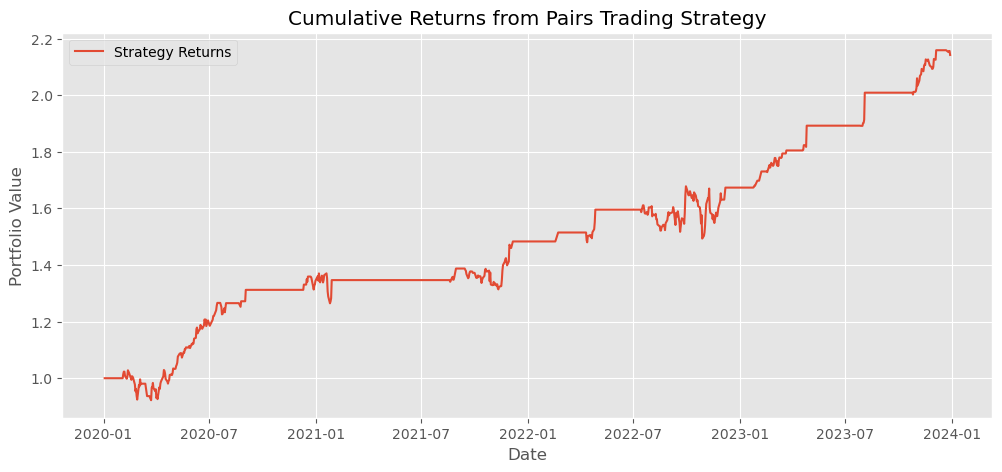

In [31]:
def plot_cumulative_returns(cum_returns):
    """
    Plots cumulative returns of the trading strategy.

    Parameters:
    cum_returns (pd.Series): Cumulative returns over time.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(cum_returns, label='Strategy Returns')
    plt.title("Cumulative Returns from Pairs Trading Strategy")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cumulative_returns(cum_returns)


In [32]:
def compute_pnl_metrics(strat_returns):
    """
    Computes daily PnL and drawdown stats.

    Parameters:
    strat_returns (pd.Series): Daily strategy returns.

    Returns:
    pd.DataFrame: DataFrame with daily return, cumulative return, drawdown.
    """
    pnl = pd.DataFrame(index=strat_returns.index)
    pnl['Daily Return'] = strat_returns
    pnl['Cumulative Return'] = (1 + strat_returns).cumprod()
    pnl['Cumulative Max'] = pnl['Cumulative Return'].cummax()
    pnl['Drawdown'] = pnl['Cumulative Return'] / pnl['Cumulative Max'] - 1
    return pnl

# Usage
strat_returns = signals.shift(1) * (returns['AAPL'] - hedge_ratio * returns['MSFT'])  # again, avoid lookahead
pnl_df = compute_pnl_metrics(strat_returns)
pnl_df.head()


,Daily Return,Cumulative Return,Cumulative Max,Drawdown
Date,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.0000,1.0000,1.0000,0.0000
2020-01-06,0.0000,1.0000,1.0000,0.0000
2020-01-07,0.0000,1.0000,1.0000,0.0000
2020-01-08,0.0000,1.0000,1.0000,0.0000


In [33]:
def apply_trading_costs(signals, strat_returns, cost_per_trade=0.001):
    """
    Deducts a fixed cost whenever a signal changes (position flip).

    Parameters:
    signals (pd.Series): Trading signals (+1, -1, 0).
    strat_returns (pd.Series): Strategy daily returns.
    cost_per_trade (float): Proportional cost (e.g., 0.001 = 0.1%)

    Returns:
    pd.Series: Net returns after trading costs.
    """
    trades = signals.diff().abs()
    costs = trades * cost_per_trade
    net_returns = strat_returns - costs.fillna(0)
    return net_returns

# Usage
net_strat_returns = apply_trading_costs(signals.shift(1), strat_returns)


In [34]:
def compute_rolling_hedge_ratio(y, x, window=60):
    """
    Computes a rolling hedge ratio using a linear regression over a moving window.

    Parameters:
    y (pd.Series): First price series (e.g., AAPL).
    x (pd.Series): Second price series (e.g., MSFT).
    window (int): Rolling window size.

    Returns:
    pd.Series: Rolling hedge ratio.
    """
    hedge_ratios = []
    for i in range(window, len(y)):
        model = LinearRegression().fit(x[i-window:i].values.reshape(-1,1), y[i-window:i].values)
        hedge_ratios.append(model.coef_[0])
    hedge_series = pd.Series([np.nan]*window + hedge_ratios, index=y.index)
    return hedge_series

rolling_hedge = compute_rolling_hedge_ratio(combined_df['AAPL'], combined_df['MSFT'])


In [36]:
def log_trades(signals, prices, ticker1='AAPL', ticker2='MSFT'):
    """
    Logs entries and exits based on signal transitions.

    Parameters:
    signals (pd.Series): Strategy signal series.
    prices (pd.DataFrame): Price DataFrame with both tickers.

    Returns:
    pd.DataFrame: Trade log with dates, positions, and prices.
    """
    log = []
    prev_sig = 0
    for date, sig in signals.items():
        if sig != prev_sig:
            log.append({
                'Date': date,
                'Signal': sig,
                f'{ticker1}_Price': prices.loc[date, ticker1],
                f'{ticker2}_Price': prices.loc[date, ticker2]
            })
        prev_sig = sig
    return pd.DataFrame(log)

trade_log = log_trades(signals, combined_df)
trade_log.head()


,Date,Signal,AAPL_Price,MSFT_Price
0,2020-02-03,1,74.7279,166.4582
1,2020-03-06,0,70.1415,154.6514
2,2020-03-13,1,67.4575,152.0288
3,2020-03-16,0,58.7793,129.6211
4,2020-03-20,1,55.6317,131.4685


In [37]:
def evaluate_strategy(pnl_df, risk_free_rate=0.02):
    """
    Computes key performance metrics for a trading strategy.

    Parameters:
    pnl_df (pd.DataFrame): DataFrame with 'Daily Return' and 'Cumulative Return'.
    risk_free_rate (float): Risk-free annual rate for Sharpe calculation.

    Returns:
    dict: Summary of performance statistics.
    """
    daily_returns = pnl_df['Daily Return']
    total_return = pnl_df['Cumulative Return'].iloc[-1] - 1
    annual_return = (1 + total_return) ** (252 / len(pnl_df)) - 1
    annual_volatility = daily_returns.std() * (252 ** 0.5)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    max_drawdown = pnl_df['Drawdown'].min()

    return {
        'Total Return': f"{total_return:.2%}",
        'Annualized Return': f"{annual_return:.2%}",
        'Annualized Volatility': f"{annual_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    }

# Usage
metrics = evaluate_strategy(pnl_df)
for k, v in metrics.items():
    print(f"{k}: {v}")


Total Return: 114.20%
Annualized Return: 21.02%
Annualized Volatility: 13.47%
Sharpe Ratio: 1.41
Max Drawdown: -11.01%


In [38]:
def trade_stats(trade_log):
    """
    Counts trade stats from the trade log.

    Parameters:
    trade_log (pd.DataFrame): Log of entry/exit signals.

    Returns:
    dict: Trade count summary.
    """
    long_trades = (trade_log['Signal'] == 1).sum()
    short_trades = (trade_log['Signal'] == -1).sum()
    total = len(trade_log)

    return {
        'Total Trades': total,
        'Long Entries': long_trades,
        'Short Entries': short_trades
    }

# Usage
stats = trade_stats(trade_log)
for k, v in stats.items():
    print(f"{k}: {v}")


Total Trades: 61
Long Entries: 10
Short Entries: 21


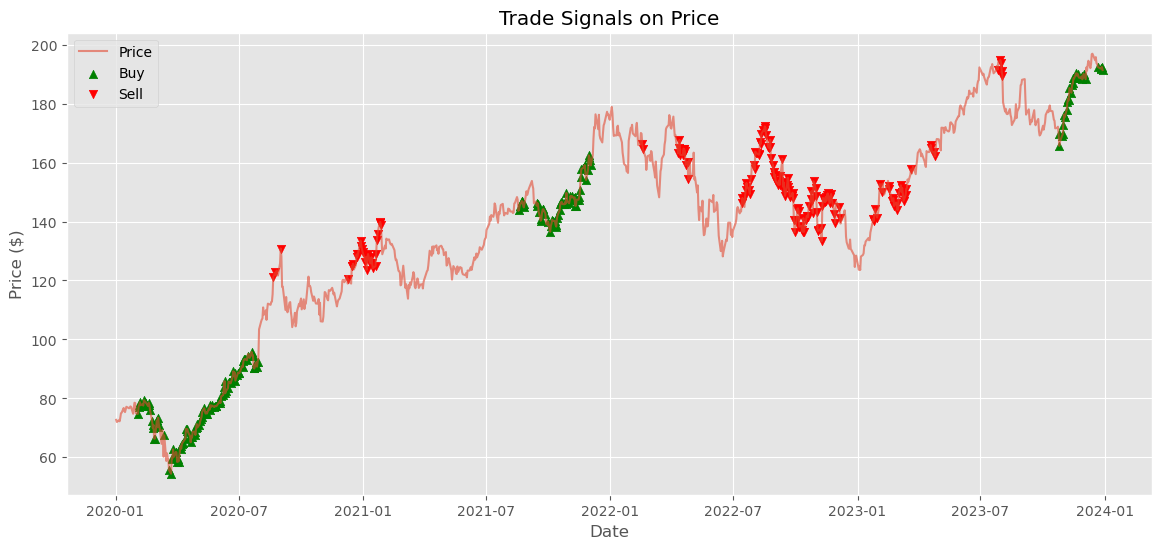

In [39]:
def plot_trade_signals(price, signals, title='Trade Signals on Price'):
    """
    Plots stock price and marks long/short entry points.

    Parameters:
    price (pd.Series): Price series of one of the assets.
    signals (pd.Series): Long/short signal series.
    title (str): Plot title.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(price, label='Price', alpha=0.6)

    buy_signals = signals[signals == 1].index
    sell_signals = signals[signals == -1].index

    plt.scatter(buy_signals, price.loc[buy_signals], label='Buy', marker='^', color='green')
    plt.scatter(sell_signals, price.loc[sell_signals], label='Sell', marker='v', color='red')

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example
plot_trade_signals(combined_df['AAPL'], signals)


In [40]:
from itertools import product


In [41]:
pnl_df.to_csv('outputs/pnl_aapl_msft.csv')
trade_log.to_csv('outputs/trades_aapl_msft.csv')


OSError: Cannot save file into a non-existent directory: 'outputs'

In [42]:
import os

os.makedirs('outputs', exist_ok=True)

pnl_df.to_csv('outputs/pnl_aapl_msft.csv')
trade_log.to_csv('outputs/trades_aapl_msft.csv')
